In [61]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import metrics
import importlib
import collections
importlib.reload(metrics)

<module 'metrics' from '/Users/REDACTED/code/modular/metrics.py'>

In [62]:
def pairwise_scatterplot(s):
    fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
    for i in range(3):
        for j in range(3):
            ax[i, j].scatter(s[:, i], s[:, j])
            ax[i, j].set_xlabel(f'dim {i}')
            ax[i, j].set_ylabel(f'dim {j}')

def three_dimensional_scatterplot(s):
    assert s.shape[1] == 3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(s[:, 0], s[:, 1], s[:, 2], alpha=0.1)
    ax.set_xlabel('dim 0')
    ax.set_ylabel('dim 1')
    ax.set_zlabel('dim 2')

deterministic sources
{'mi': 9.21034037197618, 'normalized_mi': 1.0, 'naive_normalized_mi': 0.6666666666666666}
grid sources
{'mi': 2.6645352591003757e-15, 'normalized_mi': 5.785964799319722e-16, 'naive_normalized_mi': 3.8573098662131483e-16}
cut grid sources
{'mi': 0.16735798467707053, 'normalized_mi': 0.03677307419985033, 'naive_normalized_mi': 0.024515382799900218}


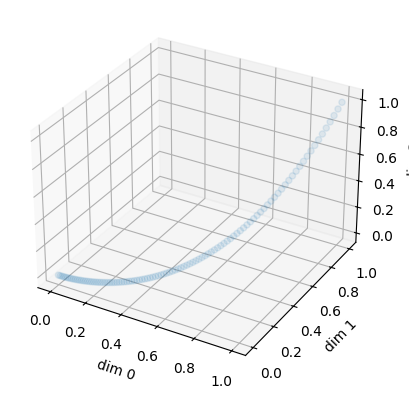

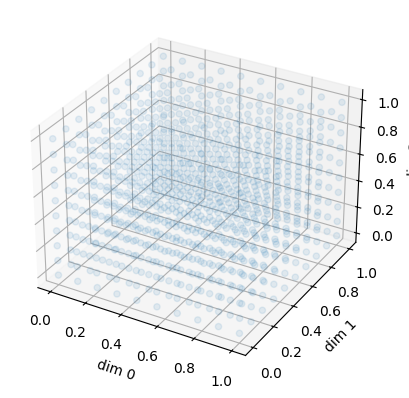

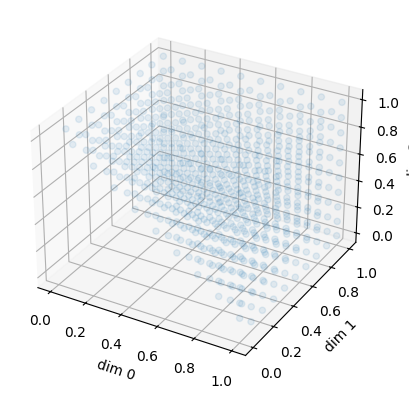

In [63]:
def test_multiinformation():
    x = np.linspace(0, 1, 100)
    y = x ** 2
    z = x ** 4
    sources = np.vstack([x, y, z]).T
    print('deterministic sources')
    print(metrics.multiinformation(sources))
    three_dimensional_scatterplot(sources)
    
    sources = np.mgrid[0:1:10j, 0:1:10j, 0:1:10j].reshape(3, -1).T
    print('grid sources')
    print(metrics.multiinformation(sources))
    three_dimensional_scatterplot(sources)
    
    sources = sources[np.sum(sources, axis=1) >= 1.01]
    print('cut grid sources')
    print(metrics.multiinformation(sources))
    three_dimensional_scatterplot(sources)
    
test_multiinformation()

In [64]:
def normalize(sources):
    mean = np.mean(sources, axis=0, keepdims=True)
    max = np.max(sources, axis=0, keepdims=True)
    min = np.min(sources, axis=0, keepdims=True)
    return (sources - mean) / (max - min)

def generate_low_d_sources(d=3, n_values_per_source=21):
    ret = {}
    np.random.seed(42)
    index = ','.join([f'0:1:{n_values_per_source}j' for _ in range(d)])
    s = eval(f'np.mgrid[{index}]')
    sources_independent = s.reshape(d, -1).T
    ret['independent'] = {'sources': normalize(sources_independent), 'nmi': metrics.multiinformation(sources_independent)['normalized_mi']}
    
    # corner cutting
    for slice in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        sources = sources_independent[np.sum(sources_independent, axis=1) >= slice - 1e-5]
        ret[f'corner:{slice}'] = {'sources': sources, 'nmi': metrics.multiinformation(sources)['normalized_mi']}
        
    # diagonal strengthening
    source_values = np.linspace(0, 1, n_values_per_source)
    sources_diagonal = np.repeat(source_values, d).reshape(-1, d)
    sources_diagonal = np.repeat(sources_diagonal, 1000, axis=0)
    sources_diagonal = sources_diagonal + np.random.uniform(-0.15, 0.15, sources_diagonal.shape)
    sources_diagonal_max, sources_diagonal_min = sources_diagonal.max(axis=0), sources_diagonal.min(axis=0)
    sources_diagonal = (sources_diagonal - sources_diagonal_min) / (sources_diagonal_max - sources_diagonal_min)
    sources_diagonal = np.round(sources_diagonal * (n_values_per_source - 1)) / (n_values_per_source - 1)
    
    for n_diagonal_samples in [10, 20, 30, 50, 100, 150, 200, 300]:
        sources_diagonal_sample = np.random.choice(sources_diagonal.shape[0], n_diagonal_samples, replace=False)
        sources = np.vstack([sources_independent, sources_diagonal[sources_diagonal_sample]])
        ret[f'diagonal_strengthen:{n_diagonal_samples}'] = {'sources': normalize(sources), 'nmi': metrics.multiinformation(sources)['normalized_mi']}
        
    # diagonal removal
    for remove in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]:
        sources = sources_independent.copy()
        cond1 = sources[:, 0] <= remove
        cond2 = np.all(np.abs(sources[:, 1:] - sources[:, 0:1]) <= 0.20, axis=1)
        sources = sources[~(cond1 & cond2)]
        ret[f'diagonal_remove:{remove}'] = {'sources': normalize(sources), 'nmi': metrics.multiinformation(sources)['normalized_mi']}
    return ret


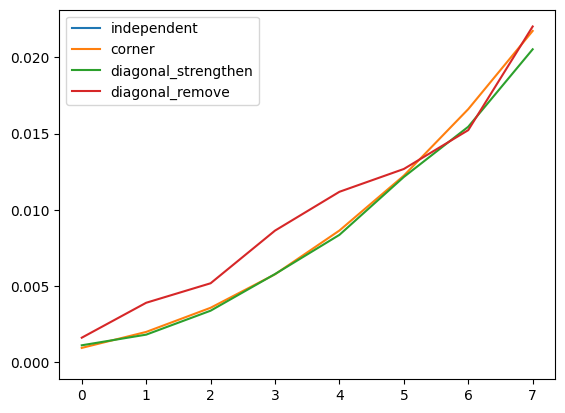

In [65]:
source_sets = generate_low_d_sources()
nmis = collections.defaultdict(list)
for k, v in source_sets.items():
    nmis[k[:k.find(':') if k.find(':') != -1 else None]].append(v['nmi'])
fig, ax = plt.subplots()
for k, v in nmis.items():
    ax.plot(np.arange(len(v)), v, label=k)
ax.legend()
# ax.set_aspect('equal')
np.savez('low_d_sources.npz', **{k: v['sources'] for k, v in source_sets.items()})

        

independent (9261, 3)
0.000
corner:0.3 (9205, 3)
0.001
corner:0.4 (9141, 3)
0.002
corner:0.5 (9041, 3)
0.004
corner:0.6 (8897, 3)
0.006
corner:0.7 (8701, 3)
0.009
corner:0.8 (8445, 3)
0.012
corner:0.9 (8121, 3)
0.017
corner:1.0 (7721, 3)
0.022
diagonal_strengthen:10 (9271, 3)
0.001
diagonal_strengthen:20 (9281, 3)
0.002
diagonal_strengthen:30 (9291, 3)
0.003
diagonal_strengthen:50 (9311, 3)
0.005
diagonal_strengthen:100 (9361, 3)
0.008
diagonal_strengthen:150 (9411, 3)
0.011
diagonal_strengthen:200 (9461, 3)
0.014
diagonal_strengthen:300 (9561, 3)
0.018
diagonal_remove:0.1 (9164, 3)
0.002
diagonal_remove:0.2 (9019, 3)
0.004
diagonal_remove:0.3 (8938, 3)
0.005
diagonal_remove:0.4 (8729, 3)
0.009
diagonal_remove:0.5 (8584, 3)
0.011
diagonal_remove:0.6 (8503, 3)
0.013
diagonal_remove:0.7 (8375, 3)
0.015
diagonal_remove:0.9 (8068, 3)
0.022


/var/folders/8x/n0fxpnwx1xb_c2jf350jk7ym0000gq/T/ipykernel_58940/3248509649.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


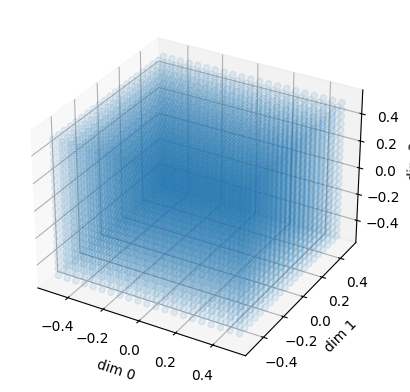

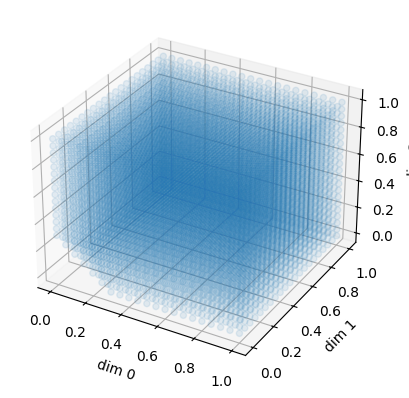

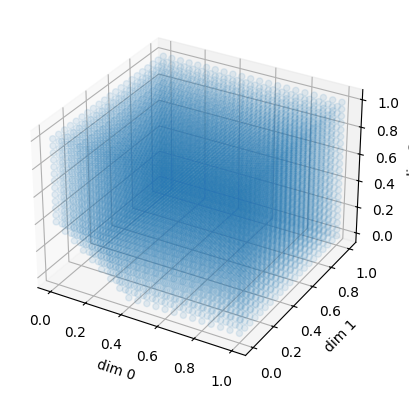

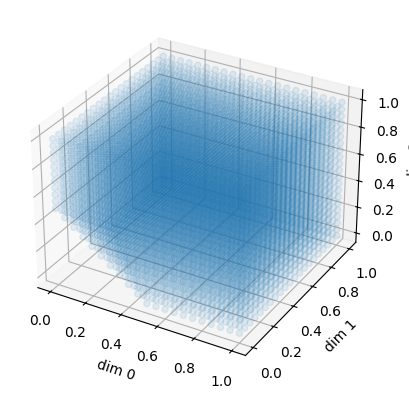

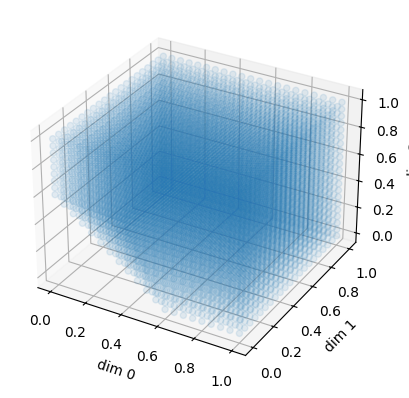

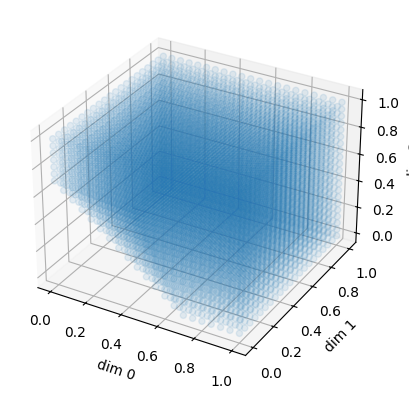

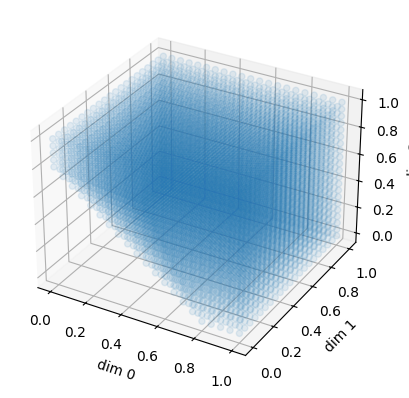

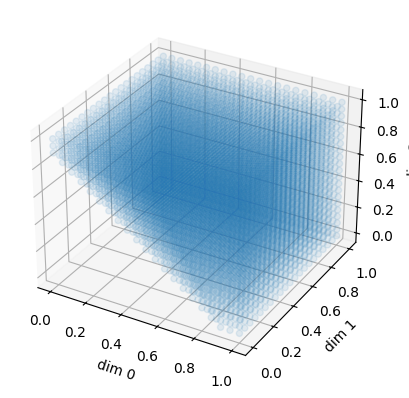

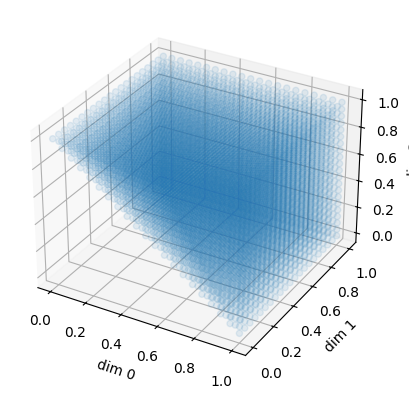

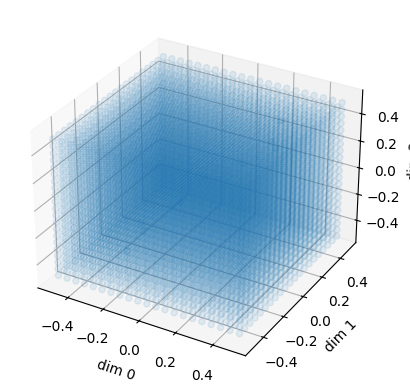

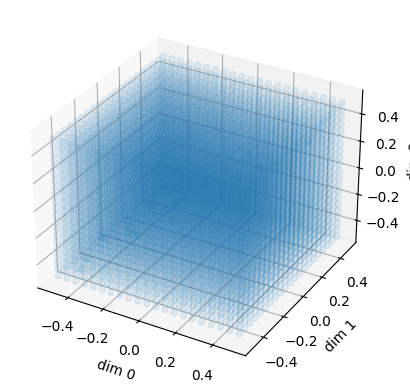

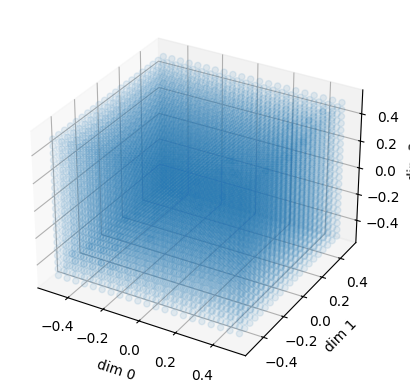

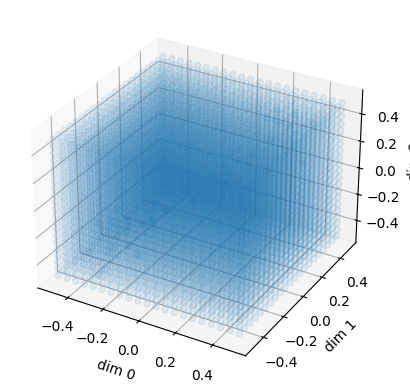

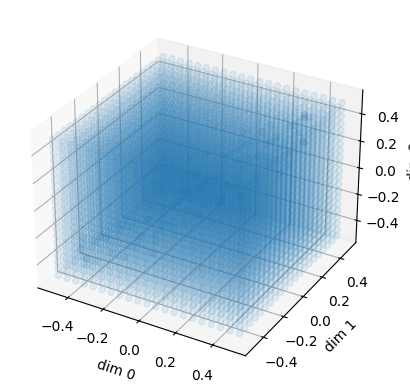

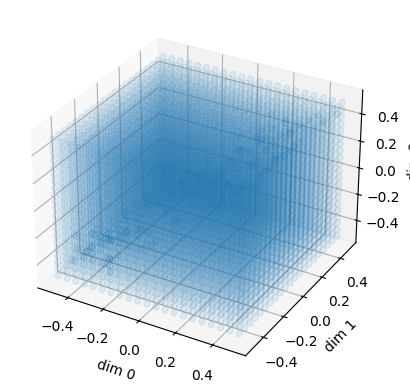

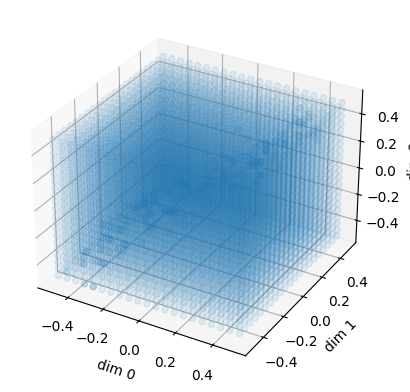

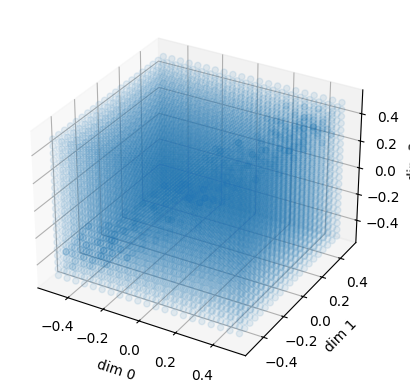

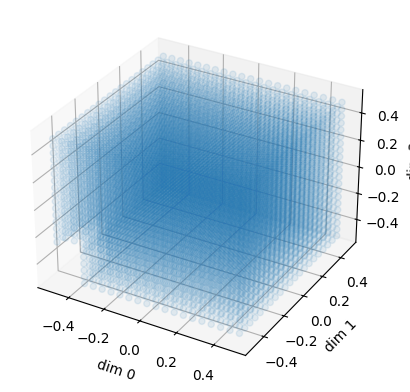

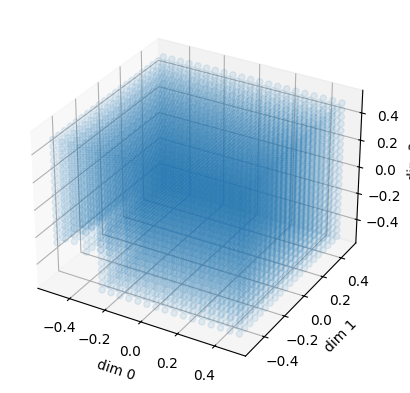

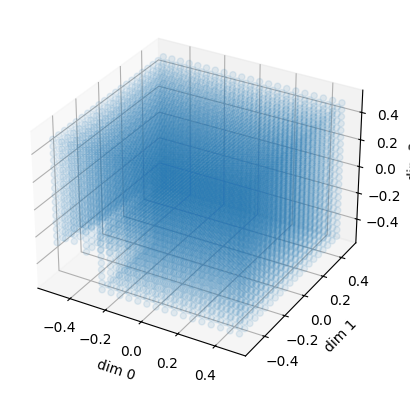

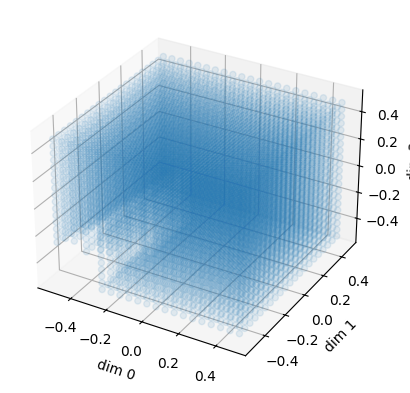

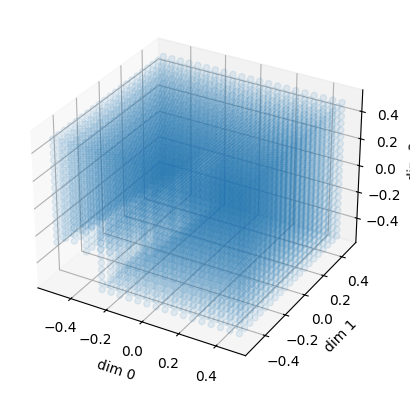

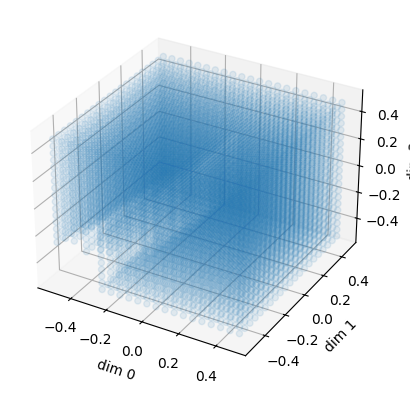

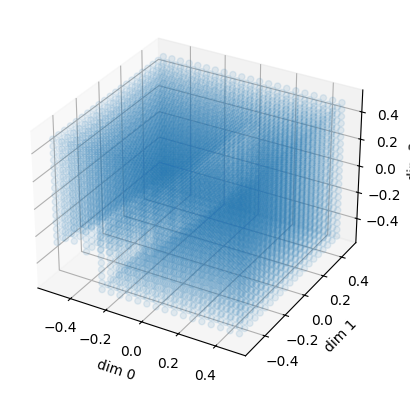

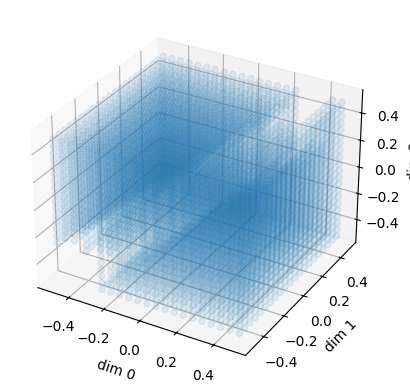

In [66]:
source_sets = np.load('low_d_sources.npz')
for k, v in source_sets.items():
    print(k, v.shape)
    print(f'{metrics.multiinformation(v)['normalized_mi']:.3f}')
    three_dimensional_scatterplot(v)